In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
#Configure Defaults
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
from tqdm import tqdm_notebook

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

Spherical k-means for document clustering
- https://lovit.github.io/nlp/machine%20learning/2018/10/16/spherical_kmeans/

In [2]:
def summary(df) :
    pd.set_option('display.max_rows', 100)
    tf = pd.DataFrame({'데이터형태(dtypes)' : df.dtypes, 
                        '비 결측치 수(notnull' : df.notnull().sum(),
                        '결측치 수(null)' : df.isnull().sum(), 
                        '고유값 수(nunique)' : df.nunique()})
    return tf

In [3]:
df = pd.read_pickle('../data/result.pkl')
# 제목이 같은 항목 삭제 및 마지막 레코드만 남김
df = df.drop_duplicates(subset=['일자','언론사', '본문'], keep="last")
df = df.dropna(subset=['특성추출(가중치순 상위 50개)'], axis=0)
df['일자'].max(); df['일자'].min()
df.head()
df.shape

Timestamp('2022-02-28 00:00:00')

Timestamp('2017-01-01 00:00:00')

,일자,언론사,통합 분류1,통합 분류2,통합 분류3,키워드,특성추출(가중치순 상위 50개),본문
8674,2020-03-20,중도일보,경제>자원,경제>유통,지역>경남,"순수,국산,수매,밀가루,시범,판매,농산물,면역,증진,효과,노화,억제,한국농수산식품유...","시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤,...","한국농수산식품유통공사(aT, 사장 이병호)는 지난해 수매한 국산 밀가루 16톤을 오..."
8675,2020-03-20,중도일보,지역>전북,지역>전남,지역>강원,"물고기,채소농사,고창군,아쿠아포닉스,채소,전국,출하,아쿠아포닉스,농법,착공,시설,출...","아쿠아포닉스,고창군,고창군청,지원사업,이영성,아쿠아포닉스코리아,재배법,수경재배,환경...",전북 고창군의 한 농장이 물고기 양식장에서 나온 유기물로 작물을 재배하는 '아쿠아포...
8678,2020-03-20,전북도민일보,지역>충북,지역>대전,지역>전북,"남부안농협,토양,개량제,무상,지원,남부안농협,조합장,최우식,로컬,푸드,농산물,생산,...","남부안농협,로컬푸드,토양개량제,직매장,농산물,고품질,무상지원,농가소득,732포,최우...",남부안농협(조합장 최우식)은 로컬푸드 고품질 농산물 생산을 위한 토양개량 지원사업...
8687,2020-03-20,충청투데이,경제>유통,경제>자원,NaN,"취나물,부여,백마강,부여군농업기술센터,남면,지역,백마강,취나물,출하,본격적,시작,1...","면역력,백마강,부여군,관계자,부여군농업기술센터,병해충,클로로젠산,농약허용물질목록관리...",[충청투데이 김일순 기자] 부여군농업기술센터는 남면 지역에서 고품질 백마강 취나물 ...
8689,2020-03-19,대전일보,지역>경기,지역>충남,경제>자원,"보령시,공모,타작물,생산,장비,지원,사업,보령,보령시,타작물,재배,확산,타작물,재배...","타작물,보령시,농업인,간척지,ha,연명부,소재지,기반정비,선별기,방제기,수확기,농기...",[보령] 보령시는 논 타작물 재배 확산을 위해 타작물 재배에 필요한 기반정비 및 생...


(570265, 8)

## 불용어 

In [4]:
data1 = pd.read_excel('../data/출현단어_5만 _박태욱.xlsx')
data2 = pd.read_excel('../data/출현단어_10만_권성희.xlsx')

data3 = pd.read_excel('../data/출현단어_15만_박태욱.xlsx')
data4 = pd.read_excel('../data/출현단어_20만_권성희.xlsx')
data = data1.append(data2).append(data3).append(data4)
data.shape

stop_words_01 = data[data['선택'] == 0]['출현단어'].tolist()
print('채택단어', len(data[data['선택'] == 1]))
print('불용어비율', len(data[data['선택'] == 0])/len(data)*100)
stop_words = list(set(stop_words_01))

for i in df.언론사.value_counts().index :
    stop_words.append(i)
for i in ['미국', '국내', '한국', '대표', '중국','일본', '가격', '글로벌', '기업', '대상', '정부', '세계', '국회', '관심', '방송'] :
    stop_words.append(i)
for i in ['인사', '발령', '공개모집', '필기시험', '발령', '인사 발령', '과장', '전보', '일자', '공무원', '국장', '점검', '실시'] :
    stop_words.append(i)
common = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "관련","전문가","예정","이번", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
          "총회", "대한", "통해", "한국","국내","개최","행사","우수","장관","피해","해외","일자리","박람회", "지원", "위해", "총회","국제","분야","세계",
          "식품과학","국립","시민","통합", "정책", "대해", '선정', '아시아경제']
for i in common :
    stop_words.append(i)
for i in ['두고', '농협', '시행', '식품안전', '안전', '참여', '이상', '조치', '개선', '관내', '참석', '대전', '확산', '조성', '홍보'] :
    stop_words.append(i)
for i in ['대한민국', '홈페이지', '상반기', '시간date', '이명박', '박근혜', '청와대', '위원회',
          '그동안', '1만', '회용', '사람들', '앤서니', '이재명', '더불어민주당', '민주당',
         '봉준호', '시상식', '만큼','위원장', '관계자', '서울', '국민의힘', '윤석열', 'a씨', '식품의약품안전처', '식약처','소비자들', '농림축산식품부',
         '식품부', '농식품부', '소비자', '용가리',
         '의약품',
          '의약국', '제약사', '농협중앙회',
          '피임약', '항정신성의약품', '탈모약', '제품', '식품',
        #  '농산물', '축산물', '수산물',
         ]:
    stop_words.append(i)
#for i in ['호르몬', '호르몬제', '환경호르몬', '성장호르몬', '의약국', '바나나맛']:
#    stop_words.append(i)

len(list(set(stop_words)))
stop_words = list(set(stop_words))

(200000, 4)

채택단어 16133
불용어비율 91.93050000000001


183901

##  Stopwords 확인

In [7]:
sf=pd.DataFrame()
for i in np.arange(0, 100):
    #(i*100, (i+1)*100)
    sf = sf.append(pd.DataFrame([stop_words[i*100+1 :(i+1)*100]]))
sf.head()

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,타진요,영동군연합사업단,교육경비,신재식,네이버플레이스,법령바다,적성,응모자들,산업정책,인수인계,...,장생포,황체기,건강모니터링,부녀회장님,陽氣,집행잔액,녀새,정유희,자살률,양동시장
0,싱크대,기획관,오픈워터,분양사업,유지관리사업,parkks,취약지,정치계,제이월드산업,가상자산사업자,...,성조기,종정,김두규,화악산,갈대밭,저금리,아시아인들,개보위,미시령,에스
0,전환경,저그,옛집,김영탁,프롬프터,논산천,최저임금제,시상세포,태양광발전,청정대기기획과,...,모스트바이,부대변인,아침저널,적폐,제작실,1700t,유베프,밀수업자,이중잠금,한명숙
0,아지트로마이신,식사권,하야노,문탠,제이디파워,라이프케어,서정호,관리,금속탐지기,인연,...,정치학자,이인지구,줄리아,행진곡,뉴스하이킥,중신그룹,동진지사,무인결제,부지점장,로런스
0,외분비,꼬리소참진드기,부인암,마을관리소,오엘라,람다256,김진희,원성수,유희문,갱신계약,...,영산강환경청,이주호,구호복지팀장,전환가액,19위,복지취약시설,별세,심해용,쏘피,1444만


# 단순분석

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer

# 시작년도, 끝년도 지정
start_year = 2017
end_year = 2022

corpus = [""] * len(df)

result_df = pd.DataFrame()

# 녇도별 문서 추출 후 키워드 빈도수 분석

for year in tqdm_notebook(range(int(start_year),int(end_year)+1)):
    start_date = str(year) + "-01-01"
    end_date = str(year) + "-12-31"
    dt_index = (df['일자'] >= start_date) & (df['일자'] <= end_date)
    temp_df = df[dt_index]

    # twitter 단어 추출이 필요없음
    #for i, fn in enumerate(temp_df['특성추출(가중치순 상위 50개)']) :
    #    corpus[i] = " ".join(twitter.nouns(fn))
    
    corpus = []
    for keywords in temp_df['특성추출(가중치순 상위 50개)']:
        corpus.append(keywords)    
       
        
    vect = CountVectorizer(stop_words = stop_words, ngram_range=(1, 1), min_df= 0.005, max_df= 0.8)
    X = vect.fit_transform(corpus)
    X = TfidfTransformer().fit_transform(X)
        
    count = X.toarray().sum(axis=0)
    idx = np.argsort(-count)
    count = count[idx]

    feature_name = np.array(vect.get_feature_names())[idx]

    result = list(zip(feature_name, count))
    result = pd.DataFrame(result)
    result.columns=[str(year) + ' 키워드','빈도수']
    result_df = pd.concat([result_df,result],axis=1)
    
result_df.head(10)

  0%|          | 0/6 [00:00<?, ?it/s]

,2017 키워드,빈도수,2018 키워드,빈도수,2019 키워드,빈도수,2020 키워드,빈도수,2021 키워드,빈도수,2022 키워드,빈도수
0,중금속,883.191723,발암물질,1128.327514,중금속,1566.196475,온라인,5449.200508,온라인,15368.806465,온라인,5456.577230
1,발암물질,674.667856,중금속,1118.229899,온라인,1254.138842,농산물,2864.692554,농산물,10864.288426,농산물,2507.138611
2,곰팡이,496.600041,건강기능식품,755.674895,오염수,1213.336072,축산물,2227.635475,수산물,5671.340295,소상공인,1795.437354
3,대장균,448.490958,곰팡이,719.191395,곰팡이,1062.493011,안전성,1686.621811,오염수,4402.498883,수산물,949.880395
4,첨가물,409.129971,온라인,662.703668,건강기능식품,1049.533882,수산물,1559.778693,안전성,4038.828320,친환경,923.728557
5,유해물질,365.776592,첨가물,584.674660,농산물,956.914587,면역력,1431.017082,소상공인,3501.606897,농업인,907.597793
6,온라인,348.757824,대장균,546.791152,발암물질,829.783688,농업인,1358.552201,친환경,3044.239336,안전성,839.053349
7,안전성,325.057738,제품,543.744388,안전성,789.505952,대장균,1293.172756,음식점,2981.486573,식품,692.636731
8,제품,269.428387,단백질,524.697958,단백질,754.034338,단백질,1266.352006,농업인,2921.205763,음식점,665.442472
9,화합물,257.854184,농산물,512.188305,수산물,702.246833,건강기능식품,1195.890338,축산물,2903.037285,단백질,661.154601


# 코로나 전후 데이터 분석

In [81]:
df.shape

(570265, 8)

# 코로나 전후 지정, 1은 코로나 이후 0은 코로나 발생 이전

In [82]:
base_date = '2020-04-20'

df['코로나전후'] = 1
df.loc[df['일자'] < base_date, '코로나전후'] = 0
print('코로나 전 최대 일자는')
df[df['코로나전후'] == 0]['일자'].max()

코로나 전 최대 일자는


Timestamp('2020-04-19 00:00:00')

In [16]:
corpus = [""] * len(df)

result_df = pd.DataFrame()

# 녇도별 문서 추출 후 키워드 빈도수 분석

for corona in tqdm_notebook(range(2)):
    
    temp_df = df[df['코로나전후'] == corona]
    
    corpus = []
    for keywords in temp_df['특성추출(가중치순 상위 50개)']:
        corpus.append(keywords)    
       
        
    vect = CountVectorizer(stop_words = stop_words, ngram_range=(1, 1), min_df= 0.00025, max_df= 0.9)
    X = vect.fit_transform(corpus)
    X = TfidfTransformer().fit_transform(X)
        
    count = X.toarray().sum(axis=0)
    idx = np.argsort(-count)
    count = count[idx]

    feature_name = np.array(vect.get_feature_names())[idx]

    result = list(zip(feature_name, count))
    result = pd.DataFrame(result)
    result.columns=['코로나_' + str(corona) + ' 키워드', '빈도수']
    result_df = pd.concat([result_df,result],axis=1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
data = result_df.fillna(0)
data.columns = ['코로나_전 단어', '빈도_전', '코로나_후 단어', '빈도_후']
data

,코로나_전 단어,빈도_전,코로나_후 단어,빈도_후
0,중금속,2931.282724,온라인,21189.120017
1,온라인,2570.266218,농산물,9384.097025
2,발암물질,2230.902265,수산물,5370.493176
3,곰팡이,2020.657402,소상공인,5339.029673
4,건강기능식품,1601.989367,안전성,5223.812307
...,...,...,...,...
1141,장내,15.265588,0,0.000000
1142,필수지방산,15.161685,0,0.000000
1143,혈당강화제,14.546492,0,0.000000
1144,미나리,14.098348,0,0.000000


## 1. 코로나 발생이후 사라진 단어

645

<AxesSubplot:xlabel='코로나_전 단어'>

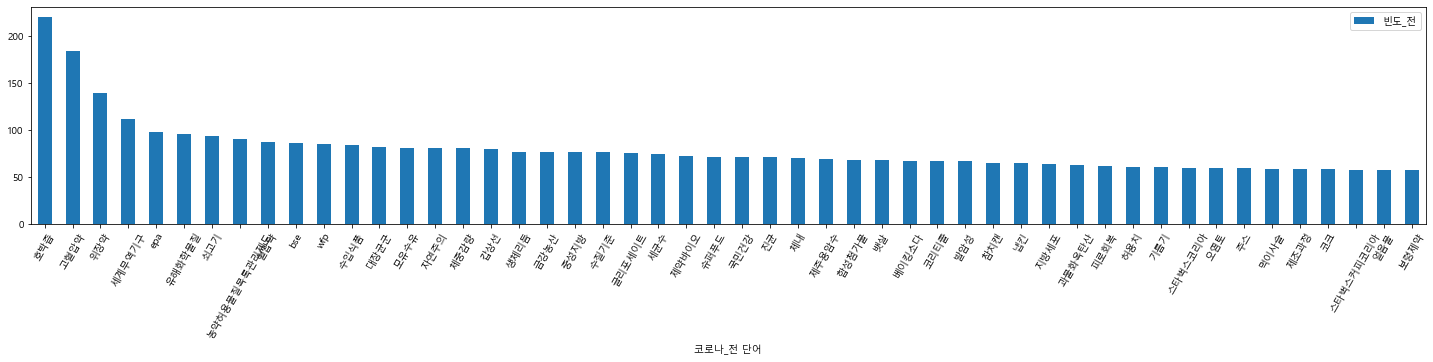

In [18]:
len(set(data['코로나_전 단어'].unique()) - set(data['코로나_후 단어'].unique()))
cor01_list = set(data['코로나_전 단어'].unique()) - set(data['코로나_후 단어'].unique())
data[data['코로나_전 단어'].isin(cor01_list)][['코로나_전 단어', '빈도_전']].set_index('코로나_전 단어')[0:50].plot(kind='bar', rot='60', figsize=(25,4)); plt.show()
data[data['코로나_전 단어'].isin(cor01_list)][['코로나_전 단어', '빈도_전']].set_index('코로나_전 단어').to_excel('../data/코로나발생후 사라진 출현단어.xlsx')

## 2. 코로나 발생이후 새로 생긴 단어

164

<AxesSubplot:xlabel='코로나_후 단어'>

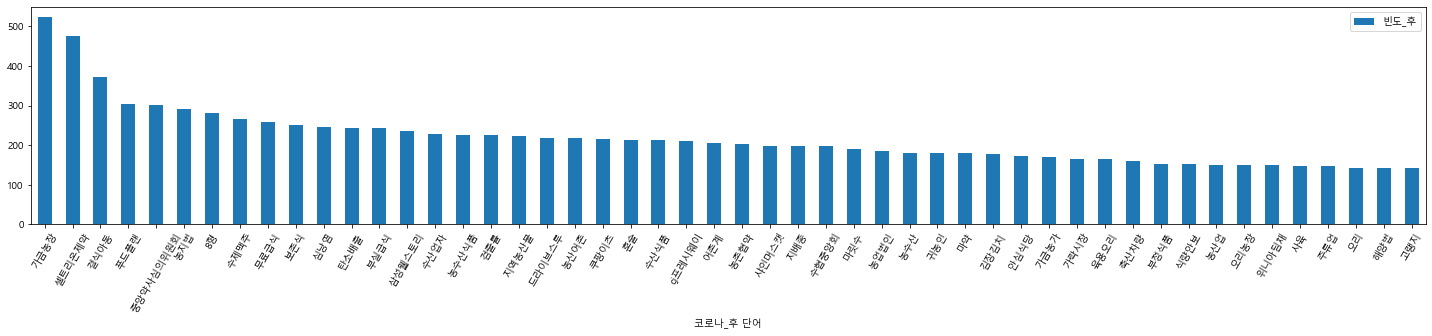

In [19]:
len(set(data['코로나_후 단어'].unique()) - set(data['코로나_전 단어'].unique()))
cor01_list = set(data['코로나_후 단어'].unique()) - set(data['코로나_전 단어'].unique())
data[data['코로나_후 단어'].isin(cor01_list)][['코로나_후 단어', '빈도_후']].set_index('코로나_후 단어')[0:50].plot(kind='bar', rot='60', figsize=(25,4)); plt.show()
data[data['코로나_후 단어'].isin(cor01_list)][['코로나_후 단어', '빈도_후']].set_index('코로나_후 단어').to_excel('../data/코로나발생 후 새롭게 출현단어.xlsx')

## 3. 코로나 전후에도 동일한 단어의 증감율

In [20]:
len(set(data['코로나_후 단어'].unique()) & set(data['코로나_전 단어'].unique()))

data_01 = data[['코로나_전 단어', '빈도_전']]
data_02 = data[['코로나_후 단어', '빈도_후']]

data1 = data_01.merge(data_02, left_on ='코로나_전 단어', right_on ='코로나_후 단어').drop('코로나_후 단어', axis=1)
data1['증감(%)'] = (data1['빈도_후'] - data1['빈도_전'])/data1['빈도_전']*100
data1 = data1.sort_values('증감(%)', ascending=False)
data1.to_excel('../data/코로나발생 전후 출현단어.xlsx')
data1

501

,코로나_전 단어,빈도_전,빈도_후,증감(%)
485,주류,21.069144,566.247141,2587.565899
405,수산업,36.471499,660.471438,1710.924856
447,급식비,28.573205,506.327759,1672.036991
303,농축수산물,53.844164,845.524764,1470.318320
416,급식실,34.422905,518.112651,1405.139248
...,...,...,...,...
72,패스트푸드점,237.345584,129.552240,-45.416200
29,호르몬,554.214809,299.376939,-45.981786
96,식품첨가물,177.215757,92.442380,-47.836253
66,gmo,268.206694,117.539142,-56.175910


# <font color='brwon'>ㅣLDA 분석

## 불용어 정리

In [6]:
from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{2,}") # 정규포현식으로 토크나이저를 정의
food_stops = set(stop_words) # 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text) 
    # stopwords 제외
    words = [word for word in tokens if (word not in food_stops) and len(word) >= 2] # 2글자 이상만
    return words

# <font color='blue'> 코로나 후 데이터만 대상

In [7]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from gensim.corpora.dictionary import Dictionary

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
base_date = '2020-01-20'

df['코로나전후'] = 1
df.loc[df['일자'] <= base_date, '코로나전후'] = 0
print('코로나 전 최대 일자는')
df[df['코로나전후'] == 0]['일자'].max()

코로나 전 최대 일자는


Timestamp('2020-01-20 00:00:00')

In [10]:
df['코로나전후'].value_counts()
tf = df[df['코로나전후'] == 1]
tf.shape

1    474591
0     95674
Name: 코로나전후, dtype: int64

(474591, 9)

In [84]:
texts = [tokenizer(news) for news in tf['특성추출(가중치순 상위 50개)']]

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]

# Create Corpus: Term Document Frequency 
# corpus = [id2word.doc2bow(text) for text in data_words if text not in stop_words]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

#Number of initial unique words in documents: 454061
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 474591


### 4개만 클러스터링
- 2개 부터 22개 LDA수행

- topic : 당신이 가설로 잡은 토픽의 갯수는?
- chunksize : 얼마나 많은 문서가 훈련 알고리즘에 사용되는가?
- 만약에 빠른 학습이 중요하시다면, 청크사이즈를 키워서 돌려봅시다!
- Hoffman의 논문에 의하면 Chunksize는 모델 품질에 영향을 미치지만 차이그 그렇게 크진 않다고 합니다!
- passes : 패스는 모델 학습시 전체 코퍼스에서 모델을 학습시키는 빈도를 제어한다고 합니다. epochs 와 같은 용어 같다! model를 학습시키는 횟수를 말하는것 같아요! model sampling?
- iteration : 각각 문서에 대해서 루프를 얼마나 돌리는지를 제어한다고 합니다.
- pass & iteration 은 최대한 많은게 좋다!
- eval_every = 1 in LdaModel
- alpha, eta = auto, 디리클레 분포의 감마함수에 대한 파라미터입니다!

In [16]:
from gensim.models import LdaModel
import pyLDAvis.gensim
from tqdm import tqdm
from datetime import date

for num_topics in  tqdm(np.arange(7,8)):
    passes = 5
    %time model = LdaModel(corpus=corpus, id2word=dictionary,\
                           passes=passes, num_topics=num_topics, \
                           random_state=7)

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

    pyLDAvis.save_html(vis, '../img/코로나후_' + str(num_topics) + '_topics_' + str(date.today()) + '---' + '.html')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Wall time: 2min 13s


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [02:32<00:00, 153.00s/it]


## Topic 벡터와 해당 단어 확인

In [20]:
topics = model.print_topics() # (num_words=10)
for topic in topics:
    print(topic)

(0, '0.252*"축산물" + 0.051*"호르몬" + 0.051*"원산지" + 0.040*"환경호르몬" + 0.030*"추출물" + 0.019*"식감" + 0.018*"축산농가" + 0.016*"bpa" + 0.015*"농식품" + 0.014*"간편식"')
(1, '0.114*"농산물" + 0.103*"단백질" + 0.059*"미생물" + 0.042*"식재료" + 0.033*"건강" + 0.029*"유산균" + 0.023*"농업인" + 0.018*"비건" + 0.017*"매일유업" + 0.017*"프로바이오틱스"')
(2, '0.147*"오염수" + 0.089*"안전성" + 0.060*"유통기한" + 0.052*"음식물" + 0.043*"영양소" + 0.030*"불량식품" + 0.026*"원재료" + 0.025*"건강관리" + 0.022*"위생법" + 0.021*"지하수"')
(3, '0.376*"온라인" + 0.118*"중금속" + 0.077*"소상공인" + 0.035*"정수기" + 0.033*"유해물질" + 0.030*"화합물" + 0.016*"호르몬제" + 0.012*"가정간편식" + 0.010*"신경세포" + 0.010*"불량식품"')
(4, '0.209*"친환경" + 0.049*"대장균" + 0.045*"식중독" + 0.038*"멜라토닌" + 0.025*"섭취량" + 0.024*"위생" + 0.023*"식중독균" + 0.022*"농가" + 0.021*"식료품" + 0.018*"밥상"')
(5, '0.092*"수산물" + 0.078*"면역력" + 0.063*"음식점" + 0.054*"돼지고기" + 0.046*"첨가물" + 0.032*"식습관" + 0.027*"이물질" + 0.024*"가공식품" + 0.021*"화학물질" + 0.020*"맥도날드"')
(6, '0.041*"냉장고" + 0.037*"에스트로겐" + 0.036*"생산자" + 0.031*"소고기" + 0.030*"건강기능식품" + 0.029*"농축산물" + 0.027*"아이스크림" + 0

## 각 Topic의 추세확인

In [86]:
for i, topic_list in enumerate(model[corpus]):
    if i==5:
        break
    print(i,'번째 문서의 topic 비율은',topic_list)

0 번째 문서의 topic 비율은 [(0, 0.02857192), (1, 0.2285741), (2, 0.02857192), (3, 0.02857192), (4, 0.02857192), (5, 0.02857192), (6, 0.62856627)]
1 번째 문서의 topic 비율은 [(0, 0.46042284), (1, 0.4601889), (2, 0.01587765), (3, 0.01587765), (4, 0.01587765), (5, 0.01587765), (6, 0.01587765)]
2 번째 문서의 topic 비율은 [(0, 0.023822898), (1, 0.35735103), (2, 0.19009833), (3, 0.0238229), (4, 0.19051082), (5, 0.023822898), (6, 0.19057113)]
3 번째 문서의 topic 비율은 [(0, 0.028689327), (1, 0.42688116), (2, 0.22881353), (3, 0.028689284), (4, 0.028689297), (5, 0.22954813), (6, 0.028689278)]
4 번째 문서의 topic 비율은 [(0, 0.028586656), (1, 0.42833948), (2, 0.028586656), (3, 0.028586656), (4, 0.22865815), (5, 0.22865571), (6, 0.028586656)]


In [89]:
doc_topics =[]
for topic_list in tqdm(model[corpus]):
    ulist =[]
    for j in range(len(topic_list)):
        ulist.append(topic_list[j][1]) # topic 이 5개인 경우도 있음 모두 9개는 아님
    doc_topics.append(ulist)

100%|███████████████████████████████████████████████████████████████████████| 474591/474591 [00:38<00:00, 12336.45it/s]


In [88]:
trend_data = pd.DataFrame(doc_topics)
trend_data['start'] = tf['일자'].values
trend_data = trend_data.set_index('start')
trend_data = trend_data.resample('M').mean()
trend_data#.background_gradient(cmap='Blues')

,0,1,2,3,4,5,6
start,,,,,,,
2020-01-31,0.153336,0.146543,0.142357,0.139294,0.129976,0.144893,0.143677
2020-02-29,0.138815,0.149262,0.138841,0.147032,0.128498,0.160611,0.137006
2020-03-31,0.135007,0.154654,0.143027,0.145126,0.132824,0.150973,0.138409
2020-04-30,0.138629,0.166390,0.135565,0.144416,0.128331,0.147902,0.138837
2020-05-31,0.135183,0.164687,0.135836,0.143170,0.129517,0.150950,0.140744
2020-06-30,0.140738,0.154853,0.129276,0.140936,0.160536,0.136277,0.137418
2020-07-31,0.137893,0.164567,0.135973,0.152461,0.137729,0.135623,0.135770
2020-08-31,0.145218,0.167995,0.134272,0.141743,0.129736,0.139864,0.141172
2020-09-30,0.142171,0.161737,0.136999,0.148740,0.123400,0.139756,0.147246


Text(0.5, 1.0, '0')

Text(0.5, 1.0, '1')

Text(0.5, 1.0, '2')

Text(0.5, 1.0, '3')

Text(0.5, 1.0, '4')

Text(0.5, 1.0, '5')

Text(0.5, 1.0, '6')

Text(0.5, 1.0, '시간별 Topic 추세선')

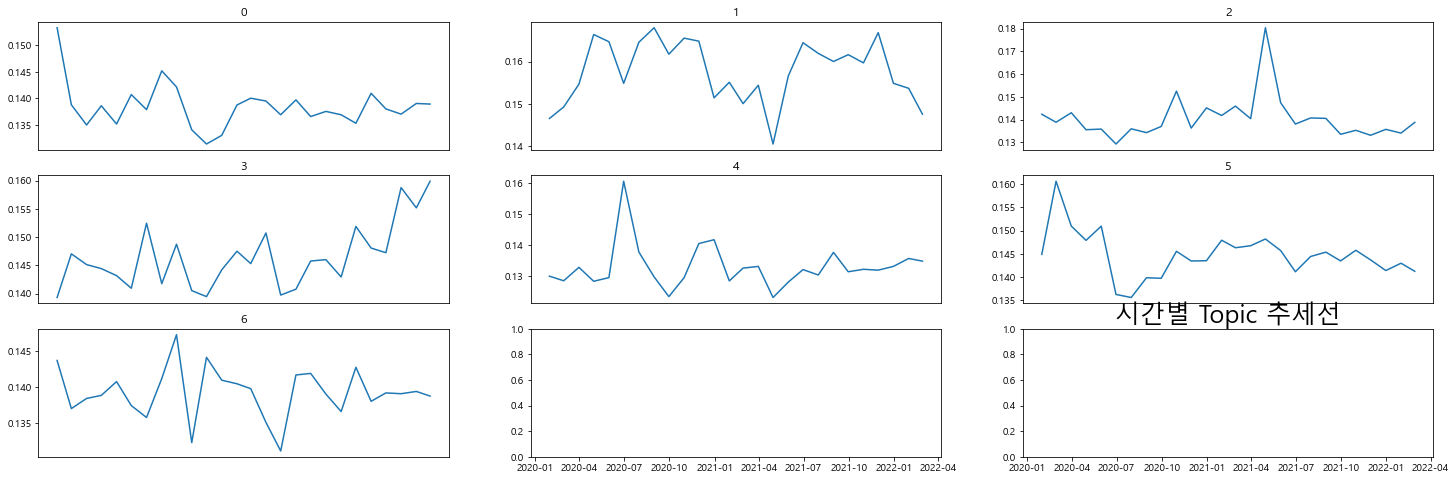

In [99]:
fig, axes = plt.subplots(3, 3, sharex='col', figsize=(25, 8)) 
for col, ax in zip(trend_data.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend_data[col])
plt.title('시간별 Topic 추세선', fontsize=25)
plt.show()

<Figure size 1440x360 with 0 Axes>

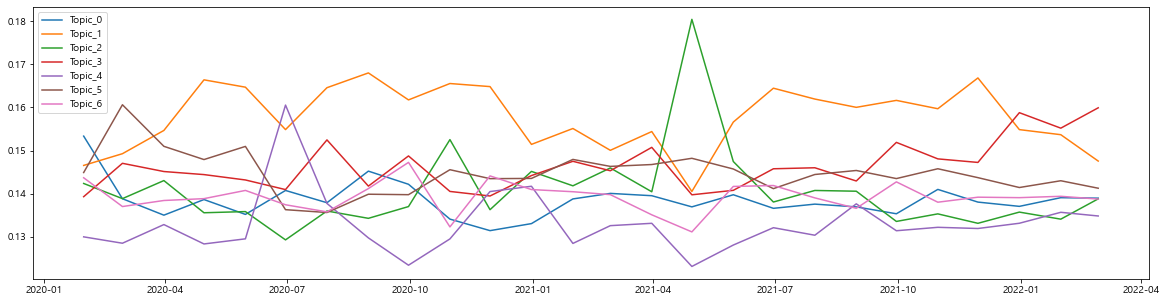

In [106]:
plt.figure(figsize=(20, 5))
plt.plot(trend_data)
plt.legend(labels=('Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6'), loc='best')

## 연관단어를 구하기 위해 단어장 만들기

In [27]:
from gensim.models import Word2Vec
corpus = [tokenizer(news) for news in tf['특성추출(가중치순 상위 50개)']]
wv_model = Word2Vec(sentences=corpus, size=100, window=5, min_count=50, workers=4, sg=0)

word_vectors = wv_model.wv
word_vectors
vocabs = word_vectors.vocab.keys()
vocabs
word_vectors_list = [word_vectors[v] for v in vocabs]
len(word_vectors_list)

dict_keys(['밀가루', '농산물', '웰빙', '로컬푸드', '재배법', '미래농업', '농어촌', '무농약', '식감', '양식장', '농특산물', '토양개량제', '농가소득', '미생물', '면역력', '농약허용물질목록관리제도', '채소류', '조리과정', '타작물', '농업인', '수확기', '농기계', '농업기술센터', '스마트팜', '농약', '이물질', '오염물질', '영양분', '식습관', '껍질째', '안전성', '순살', '온라인', '식재료', '돼지고기', '식품업계', '손맛', '농사', '농자재', '농식품', '농작업', '친환경', '오가닉', '농업기술', '농진청', '농약안전보관', '농약병', '폐농약', '영농철', '건강관리', '농기구', '병원균', '농업기계', '농업', '가지', '축산농가', '농축산', '가축질병', '축종', '사육', '봄나물', '식중독', '식중독균', '냉장고', '영양소', '섭취', '소상공인', '구내식당', '농어업', '먹잇감', '농가', '항산화', '생산자', '유용미생물', '농작물', '유산균', '유해균', '글루탐산', '사료비', '유통경로', '방제약제', '과수농가', '하나로마트', '잔류농약', '농축협', '영농', '농가소득증대', '소독약', '원재료', '유기질', '농공단지', '농경지', '쌀값', '농지소재지', '농업인들', '농업소득', '도매시장', '농수산물', '농생명', '식물', '채소', '뿌리', '농기센터', '주말농장', '산나물', '농가들', '예산군농업기술센터', '유기농', '작물', '농업기술원', '식물체', '재배농가', '총채벌레', '엽채류', '블루베리', '작물보호제', '향신료', '음식점', '식생활', '막걸리', '한국농수산식품유통공사', '영농폐기물', '농약살포', '학교급식', '지역농산물', '공공급식', '무상급식비', '학교급식지원센터', '급식지원센터', '재배기술', '음료

1544

In [29]:
words = []
for i in range(0, model.num_topics):
    #print('Topic', i)
    for token, score in model.show_topic(i):
        #(token, score)
        words.append(token)
    #print('*'*100)

In [30]:
words[0:10]

['축산물', '호르몬', '원산지', '환경호르몬', '추출물', '식감', '축산농가', 'bpa', '농식품', '간편식']

In [31]:
my_dict = {'Topic_' + str(i): [token for token, score in model.show_topic(i, topn=10)] for i in range(0, model.num_topics)}
my_dict.keys()

dict_keys(['Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6'])

In [42]:
cos ={}
co = []
for word in words:
    co.append([word, wv_model.wv.most_similar(word)])
    cos.update(wv_model.wv.most_similar(word))

In [80]:
data = pd.DataFrame(co, columns=['단어', '연관단어'])
data['topic'] = 0
for i in range(8):
    #i*10, ((i+1)*9+i)
    data.loc[i*10:((i+1)*9+i)+1, 'topic'] = i+1
data
data.to_excel('../data/토픽별_연관어.xlsx')

,단어,연관단어,topic
0,축산물,"[(농축산물, 0.7456247806549072), (한우고기, 0.72612154...",1
1,호르몬,"[(흡수, 0.9811935424804688), (체내, 0.976969480514...",1
2,원산지,"[(원산지표시, 0.9081869125366211), (수입산, 0.83543211...",1
3,환경호르몬,"[(화학물질, 0.9748596549034119), (발암물질, 0.95229506...",1
4,추출물,"[(피로회복, 0.9434539675712585), (알로에, 0.936698853...",1
...,...,...,...
65,농축산물,"[(하나로마트, 0.9060804843902588), (농협하나로마트, 0.8964...",7
66,아이스크림,"[(롯데푸드, 0.9239047169685364), (삼립, 0.8989562988...",7
67,농축수산물,"[(신선식품지수, 0.894373893737793), (서울시농수산식품공사, 0.8...",7
68,닭고기,"[(오리고기, 0.928501307964325), (돼지고기, 0.913836359...",7


### 혼란도와 토픽 응집도를 이용한 최적값 선택

In [153]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

-9.852902070104767


num_topics: 3, perplexity: -6.802, coherence: -8.651
num_topics: 4, perplexity: -6.849, coherence: -9.754
num_topics: 5, perplexity: -6.899, coherence: -9.997
num_topics: 6, perplexity: -6.893, coherence: -10.784
num_topics: 7, perplexity: -6.951, coherence: -10.717
num_topics: 8, perplexity: -6.934, coherence: -11.329
num_topics: 9, perplexity: -6.995, coherence: -12.180
num_topics: 10, perplexity: -7.054, coherence: -12.585
num_topics: 11, perplexity: -7.139, coherence: -12.531
num_topics: 12, perplexity: -7.275, coherence: -12.994
num_topics: 13, perplexity: -7.692, coherence: -12.405
num_topics: 14, perplexity: -8.629, coherence: -12.342
num_topics: 15, perplexity: -9.835, coherence: -12.296


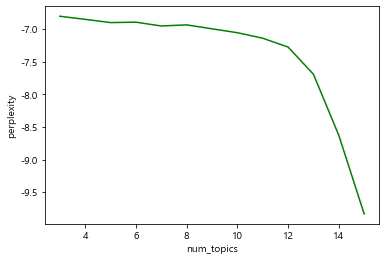

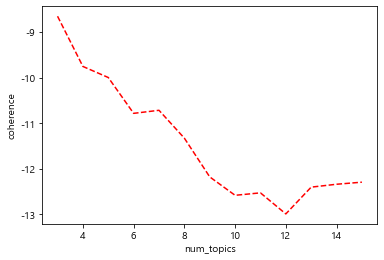

In [154]:
def show_coherence(corpus, dictionary, start=3, end=10):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=3, end=15)

## Topic에 속한 기사 단어의 코사인 유사성을 구한다

### 유사도는 −1에서 1까지의 값을 가지며, −1은 서로 완전히 반대되는 경우, 0은 서로 독립적인 경우, 1은 서로 완전히 같은 경우를 의미한다.

In [27]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
pd.options.display.float_format = '{:,.2f}'.format
cosinematrix = pd.DataFrame(cosine_similarity(word_vectors_list,dense_output=False), columns=vocabs)
cosinematrix.index = vocabs

In [36]:
# 단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그린다
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

def plot_2d_graph(vocabs, xs, ys):    
    plt.figure(figsize=(20 ,20))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

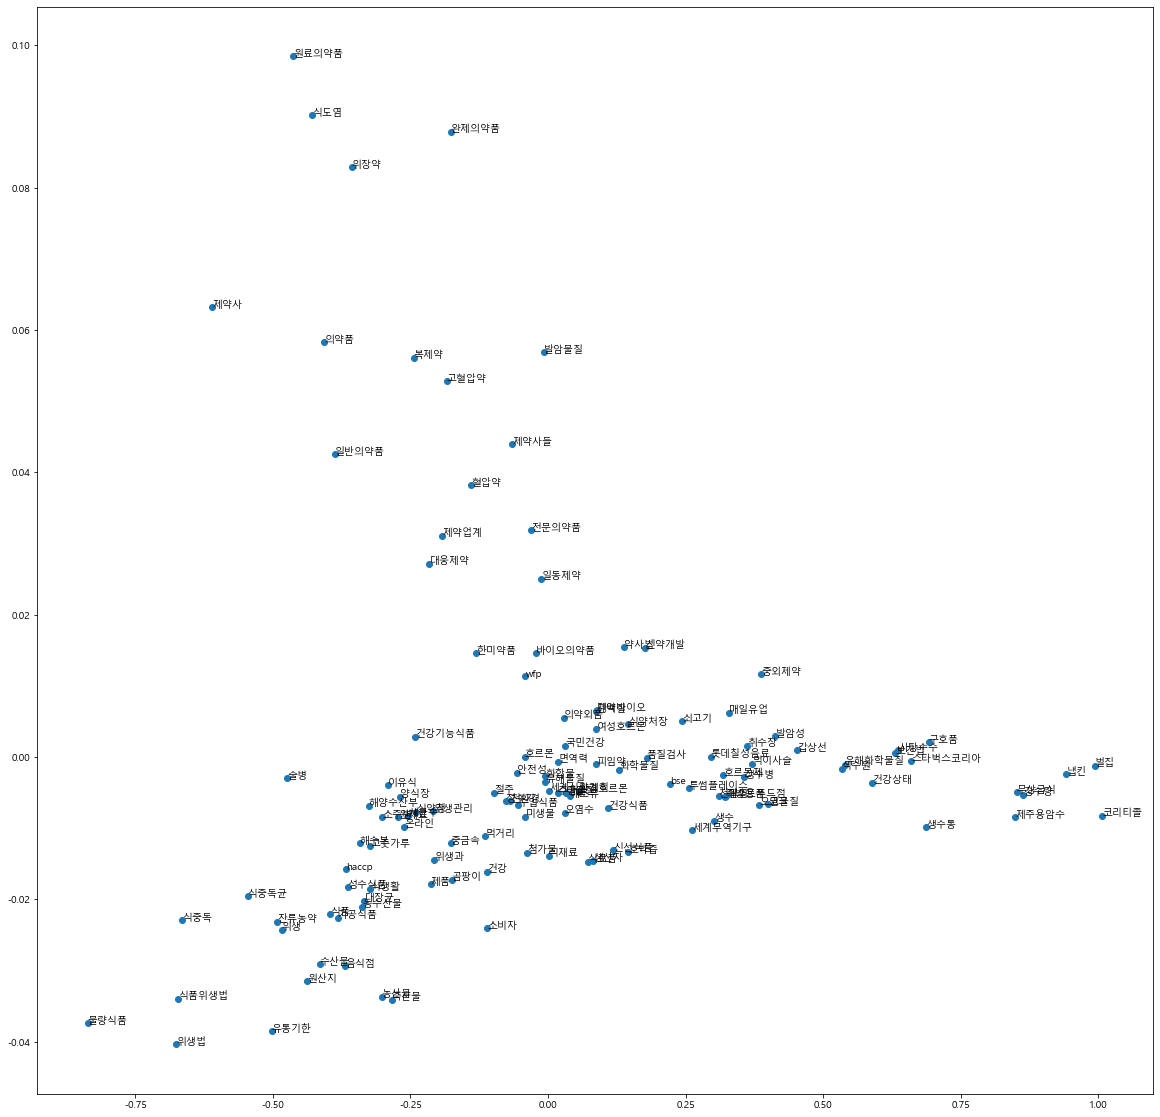

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]
 
# 결과2

plot_2d_graph(vocabs, xs, ys)

# <font color='red'> 사이킷런 LDA
## 불용어를 Countvector()에서 적용

## 특성추출(가중치순 상위 50개)로 corpus 새로이 구성

In [100]:
corpus = []

for keywords in tf['특성추출(가중치순 상위 50개)']:
    corpus.append(keywords)

corpus[:2]

['시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤,웰빙,농림축산식품부,로컬푸드,kg,발전대책',
 '아쿠아포닉스,고창군,고창군청,지원사업,이영성,아쿠아포닉스코리아,재배법,수경재배,환경오염,이영윤,미래농업,농어촌,화학비료,전라북도,물고기양식,융복합,농산물,소비자,유기물,무농약,합성어,식감,양식장,아쿠포닉스,농특산물,노지']

### 불용어 적용

In [102]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
vect = CountVectorizer(stop_words = stop_words, ngram_range=(1, 2), min_df= 0.0015, max_df= 0.9)
X = vect.fit_transform(corpus) # Doc-Term Matrix 계산
len(vect.get_feature_names())
X

#from scipy import sparse
#X.toarray()
#sparse.csr_matrix(X.toarray())
#pd.DataFrame(X.toarray(), columns = vect.get_feature_names())

116

<474591x116 sparse matrix of type '<class 'numpy.int64'>'
	with 262506 stored elements in Compressed Sparse Row format>

In [103]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(X)
# components_속성은 토픽별(row)로 1000개의 feature(단어)들의 분포수치(column)를 보여줌
print(lda.components_.shape)
print(lda.components_)

LatentDirichletAllocation(n_components=4, random_state=42)

(4, 116)
[[1.01724802e+03 9.08246224e+02 2.53504870e-01 2.58922828e-01
  7.78248661e+02 2.53403854e-01 2.52772068e-01 2.52135727e-01
  2.53544150e-01 2.54819327e-01 2.51590959e-01 2.54277350e-01
  2.65624076e+03 2.51952617e-01 2.51584007e-01 2.53201068e-01
  2.54163351e-01 2.53494011e-01 4.18240576e+00 2.55097837e-01
  2.54389763e-01 2.51958977e-01 1.23224485e+03 2.52639253e-01
  3.64349405e-01 1.58918015e+03 2.81610924e+03 2.51464454e-01
  1.48524241e+03 8.26049486e+00 2.52614417e-01 2.53328986e-01
  2.51154237e-01 2.53055208e-01 1.01824382e+03 5.73167840e+02
  2.54341318e-01 6.36137543e-01 2.52728811e-01 4.72351902e+01
  9.61047958e+02 2.51494501e-01 3.58656534e+02 8.14246482e+02
  2.88139224e-01 4.08622084e+03 2.51133209e-01 3.86511252e-01
  2.52484132e-01 1.18624431e+03 2.51658709e-01 3.44907642e-01
  2.52316342e-01 2.69557173e+03 1.32624555e+03 7.16186557e+02
  2.56562044e-01 2.52903030e-01 9.92748969e+03 1.07421851e+03
  2.52729841e-01 2.55781533e-01 2.53227318e-01 2.68883885e-01

In [104]:
# 이 때 lda_model이란, 벡터화시킨 텍스트 데이터를 fit까지만 적용한 모델!
def display_topic_words(lda_model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(lda_model.components_):
        print('\nTopic #', topic_idx+1)
        
        # Topic별로 1000개의 단어들(features)중에서 높은 값 순으로 정렬 후 index를 반환해줌!
        # argsort()는 디폴트가 오름차순임(1,2,3,...) 그래서 [::-1]로 내림차순으로 바꿔주기
        topic_word_idx = topic.argsort()[::-1]
        top_idx = topic_word_idx[:num_top_words]
        
        # CountVectorizer함수 할당시킨 객체에 get_feature_names()로 벡터화시킨 feature(단어들)볼 수 있음!
        # 이 벡터화시킨 단어들(features)은 숫자-알파벳순으로 정렬되며, 단어들 순서는 fit_transform시키고 난 이후에도 동일!
        # '문자열'.join 함수로 특정 문자열 사이에 끼고 문자열 합쳐줄 수 있음.
        feature_concat = '+'.join([str(feature_names[i])+'*'+str(round(topic[i], 1)) for i in top_idx])
        print(feature_concat)    
        
feature_names = vect.get_feature_names()
display_topic_words(lda, feature_names, 15)


Topic # 1
수산물*9927.5+음식점*4944.3+면역력*4086.2+농식품*2816.1+생산자*2695.6+곰팡이*2656.2+해수부*1826.2+축산*1649.2+농수산물*1589.2+영양소*1580.2+해양수산부*1560.2+이물질*1544.2+지하수*1489.2+농어촌*1485.2+원재료*1479.2

Topic # 2
안전성*7577.2+오염수*6169.2+건강기능식품*3727.2+건강*3663.2+중금속*2857.2+위생*2284.2+급식*2254.2+농가*1988.3+유산균*1976.2+급식소*1473.2+농업*1468.3+건강식품*1365.2+오염물질*1323.2+정수기*1277.2+농기계*1275.2

Topic # 3
농산물*20887.1+축산물*6755.8+소상공인*6523.2+농업인*6219.5+친환경*5138.2+단백질*5078.8+원산지*2373.1+냉장고*2052.2+돼지고기*1964.2+농작물*1898.2+농축산물*1699.2+특산물*1669.2+식생활*1655.2+식재료*1572.5+로컬푸드*1572.2

Topic # 4
온라인*29783.2+미생물*3169.4+대장균*2692.2+음식물*2460.2+식중독*2356.8+건강관리*2327.2+식재료*1727.3+간편식*1588.2+식감*1246.2+밀키트*988.2+신선식품*873.2+포도상구균*866.2+cj제일제당*840.2+짜파구리*808.2+주류*754.2


In [107]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] 
                         for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print_top_words(lda, vect.get_feature_names(), 20)

Topic #0: 수산물, 음식점, 면역력, 농식품, 생산자, 곰팡이, 해수부, 축산, 농수산물, 영양소, 해양수산부, 이물질, 지하수, 농어촌, 원재료, 생수, 농림, 바이러스, 조류인플루엔자, 식습관
Topic #1: 안전성, 오염수, 건강기능식품, 건강, 중금속, 위생, 급식, 농가, 유산균, 급식소, 농업, 건강식품, 오염물질, 정수기, 농기계, 유해물질, 화합물, 스마트팜, 농약, 프로바이오틱스
Topic #2: 농산물, 축산물, 소상공인, 농업인, 친환경, 단백질, 원산지, 냉장고, 돼지고기, 농작물, 농축산물, 특산물, 식생활, 식재료, 로컬푸드, 가공식품, 한국농수산식품유통공사, 첨가물, 유통기한, 농민들
Topic #3: 온라인, 미생물, 대장균, 음식물, 식중독, 건강관리, 식재료, 간편식, 식감, 밀키트, 신선식품, 포도상구균, cj제일제당, 짜파구리, 주류, 급식비, 외식업, 밥상, 한국농수산식품유통공사, 위생법


In [108]:
# transform까지 수행하면, 문서별(row)로 토픽들(column)의 분포를 알려줌
doc_topics = lda.transform(X)
print(doc_topics.shape)
print(doc_topics[:10])

(474591, 4)
[[0.08333341 0.08333338 0.74999983 0.08333338]
 [0.37500272 0.04166678 0.37500561 0.20832489]
 [0.06250015 0.0625003  0.56262528 0.31237426]
 [0.62499989 0.12500005 0.12500002 0.12500004]
 [0.08333342 0.42911519 0.40421796 0.08333343]
 [0.62499989 0.12500005 0.12500002 0.12500004]
 [0.62499989 0.12500005 0.12500002 0.12500004]
 [0.06250007 0.06250491 0.81249495 0.06250007]
 [0.12500012 0.62499968 0.12500008 0.12500012]
 [0.08333342 0.42911519 0.40421796 0.08333343]]


In [109]:
trend_data = pd.DataFrame(doc_topics)
trend_data['start'] = tf['일자'].values
trend_data = trend_data.set_index('start')
trend_data = trend_data.resample('M').mean()
trend_data#.background_gradient(cmap='Blues')

,0,1,2,3
start,,,,
2020-01-31,0.246822,0.252990,0.266981,0.233207
2020-02-29,0.246324,0.247041,0.245252,0.261382
2020-03-31,0.251168,0.246044,0.250380,0.252408
2020-04-30,0.244833,0.245639,0.274672,0.234856
2020-05-31,0.237636,0.255375,0.269519,0.237469
2020-06-30,0.233747,0.235988,0.263969,0.266297
2020-07-31,0.238360,0.246087,0.259688,0.255865
2020-08-31,0.252697,0.238598,0.271377,0.237328
2020-09-30,0.239474,0.244777,0.274426,0.241323


Text(0.5, 1.0, '0')

Text(0.5, 1.0, '1')

Text(0.5, 1.0, '2')

Text(0.5, 1.0, '3')

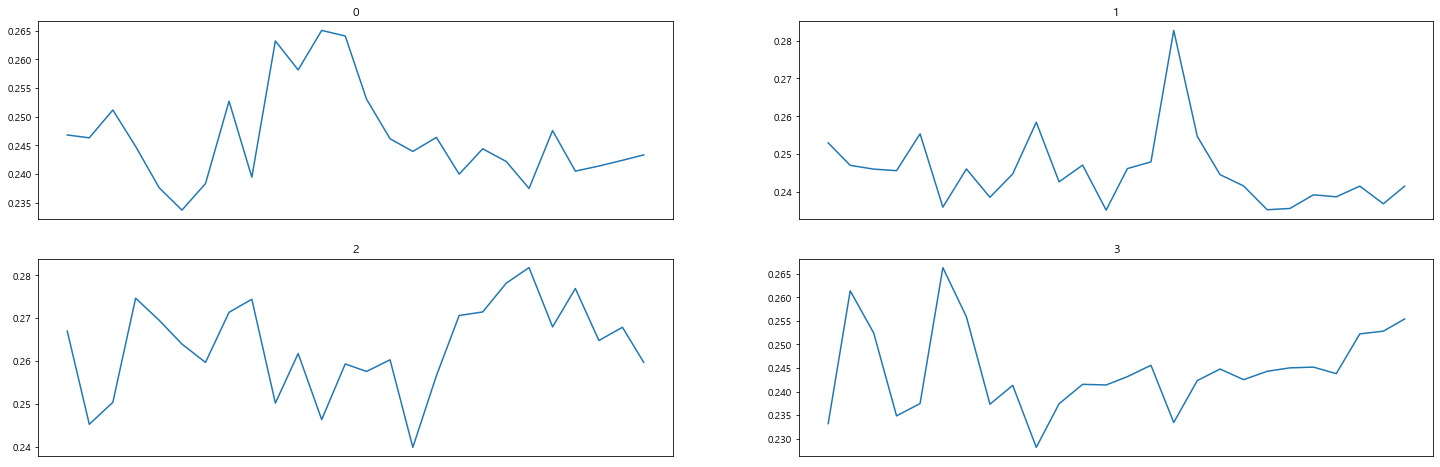

In [110]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(25, 8)) 
for col, ax in zip(trend_data.columns.tolist(), axes.ravel()): 
    ax.set_title(col)
    ax.axes.xaxis.set_visible(False)
    ax.plot(trend_data[col])
plt.show()

<Figure size 1440x360 with 0 Axes>

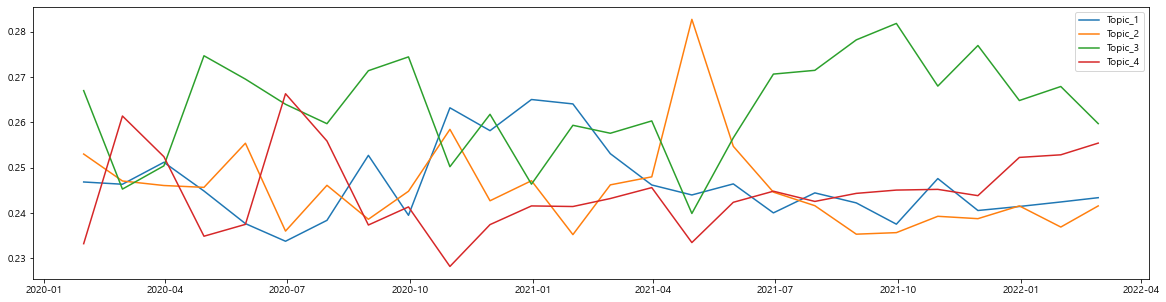

In [111]:
plt.figure(figsize=(20, 5))
plt.plot(trend_data)
plt.legend(labels=('Topic_1', 'Topic_2', 'Topic_3', 'Topic_4'), loc='best')

In [200]:
#X = TfidfTransformer().fit_transform(X)

count = X.toarray().sum(axis=0) # Doc-Term Matrix 각 단어에 대한 합

#count = np.random.permutation(X.toarray()).sum(axis=0) 행으로 permutation하여도 상관없음
idx = np.argsort(-count)
count = count[idx]

feature_name = np.array(vect.get_feature_names())[idx]
len(feature_name)
keyword_list = list(zip(feature_name, count))
result_df = pd.DataFrame(keyword_list)
result_df.head(20)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


116

,0,1
0,온라인,27587
1,농산물,19406
2,의약품,16785
3,수산물,9594
4,안전성,6990
5,소상공인,6177
6,오염수,5956
7,농업인,5793
8,축산물,5477
9,친환경,4799


In [201]:
len(vect.get_feature_names())
vect.get_feature_names()[:10]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


116

['asf', 'bpa', 'cj제일제당', '가공식품', '가금농장', '간편식', '건강', '건강관리', '건강기능식품', '건강식품']

### Topic에 속한 기사의 단어가 코사인 유사성을 구한다

In [21]:
from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{2,}") # 정규포현식으로 토크나이저를 정의
food_stops = set(stop_words) # 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text) 
    # stopwords 제외
    words = [word for word in tokens if (word not in food_stops) and len(word) >= 2] # 2글자 이상만
    return words

data = pd.DataFrame(doc_topics, columns= ['Topic #1', 'Topic #2', 'Topic #3', 'Topic #4'])

data['topic'] = np.argmax(doc_topics, axis=1)
data
data['topic'].value_counts()

df.index =np.arange(len(df))
data = df.loc[data[data['topic'] == 0].index, :]

corpus = [tokenizer(news) for news in data['특성추출(가중치순 상위 50개)']]

,Topic #1,Topic #2,Topic #3,Topic #4,topic
0,0.083334,0.083334,0.083334,0.749999,3
1,0.125000,0.125000,0.125000,0.624999,3
2,0.312552,0.062501,0.062500,0.562448,3
3,0.250000,0.250000,0.250000,0.250000,0
4,0.250023,0.050000,0.050000,0.649976,3
...,...,...,...,...,...
105574,0.067958,0.062691,0.806824,0.062527,2
105575,0.811511,0.062514,0.063046,0.062928,0
105576,0.250000,0.250000,0.250000,0.250000,0
105577,0.250000,0.250000,0.250000,0.250000,0


0    63528
2    14549
3    14025
1    13477
Name: topic, dtype: int64

In [22]:
corpus[:2]

[['노명식', '농약봉지', '농약병'], ['박혜성', '온라인', '레늄']]

In [23]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=corpus, size=100, window=5, min_count=50, workers=4, sg=0)

word_vectors = model.wv
word_vectors
vocabs = word_vectors.vocab.keys()
vocabs
word_vectors_list = [word_vectors[v] for v in vocabs]
len(word_vectors_list)

dict_keys(['온라인', '친환경', '농산물', '농수산물', '안전성', '잔류농약', '의약품', '소비자', '의약외품', '제품', '식품', '벌집', '화합물', '생산자', '유해물질', '원산지', '원재료', '수산물', '식재료', '국민건강', 'haccp', '먹이사슬', '품질검사', '화학물질', '유통기한', '수입식품', '식중독', '식약처장', '신선식품', '양식장', '해수부', '해조류', '무상급식', '롯데칠성음료', '식수원', '제약바이오', '천일염', '약사법', '제약사', '신약개발', '정수기', '해양수산부', '환경호르몬', '일동제약', '식료품', 'bse', '쇠고기', '가공식품', '건강', '패스트푸드점', '식약청', '미생물', '단백질', '먹거리', '음식점', '식품위생법', '건강기능식품', '위생법', '세계무역기구', '세계식량계획', '일반의약품', '추출물', '전문의약품', '건강식품', '위생', '성수식품', '제약사들', '제약업계', '면역력', '한미약품', '매일유업', '대웅제약', '원료의약품', '사탕수수', '축산물', '이물질', '위생과', '위생관리', '식도염', '첨가물', '복제약', '주방용품', '식생활', '건강상태', '중외제약', '식중독균', '고춧가루', '중금속', '바이오의약품', '제주용암수', '강수량', '곰팡이', '호박즙', '이유식', '취수장', '발암성', '오염물질', '유해화학물질', '술병', '생수병', '냅킨', '투썸플레이스', '절주', '대장균', '코크', '세균수', '생수', '생수통', '구호품', '소주병', '보건법', '혈압약', '발암물질', '위장약', '완제의약품', '고혈압약', '호르몬', '피임약', '갑상선', '호르몬제', '오염수', '스타벅스코리아', 'wfp', '여성호르몬', '코리티졸', '불량식품'])

126

### 유사도는 −1에서 1까지의 값을 가지며, −1은 서로 완전히 반대되는 경우, 0은 서로 독립적인 경우, 1은 서로 완전히 같은 경우를 의미한다.

In [27]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
pd.options.display.float_format = '{:,.2f}'.format
cosinematrix = pd.DataFrame(cosine_similarity(word_vectors_list,dense_output=False), columns=vocabs)
cosinematrix.index = vocabs

In [36]:
# 단어와 2차원 X축의 값, Y축의 값을 입력받아 2차원 그래프를 그린다
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

def plot_2d_graph(vocabs, xs, ys):    
    plt.figure(figsize=(20 ,20))
    plt.scatter(xs, ys, marker = 'o')
    for i, v in enumerate(vocabs):
        plt.annotate(v, xy=(xs[i], ys[i]))

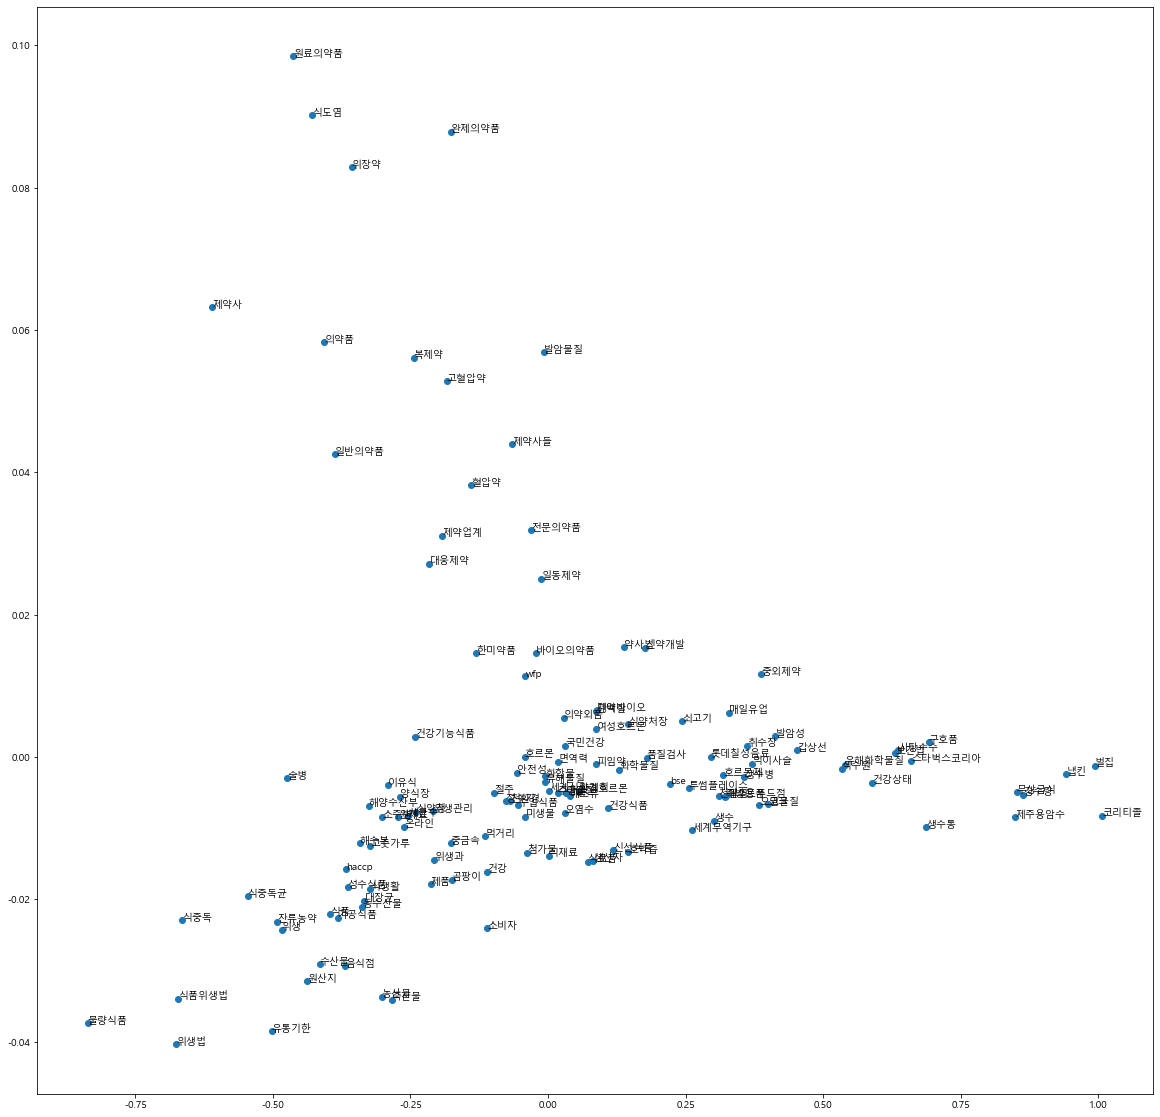

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
xys = pca.fit_transform(word_vectors_list)
xs = xys[:,0]
ys = xys[:,1]
 
# 결과2

plot_2d_graph(vocabs, xs, ys)

# 2. Gensim 패키지 
### perplex, coherence 적용 가능
### 불용어를 원래 자료에서 적용하여야 함
### https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

In [60]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 불용어 정리

In [61]:
from nltk.tokenize import RegexpTokenizer

RegTok = RegexpTokenizer("[\w']{2,}") # 정규포현식으로 토크나이저를 정의
food_stops = set(stop_words) # 불용어를 가져옴

def tokenizer(text):
    tokens = RegTok.tokenize(text) 
    # stopwords 제외
    words = [word for word in tokens if (word not in food_stops) and len(word) >= 2] # 2글자 이상만
    return words

texts = [tokenizer(news) for news in df['특성추출(가중치순 상위 50개)']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence \w
<>:3: DeprecationWarning: invalid escape sequence \w
<ipython-input-61-6fe2b0a3ad6c>:3: DeprecationWarning: invalid escape sequence \w
  RegTok = RegexpTokenizer("[\w']{2,}") # 정규포현식으로 토크나이저를 정의


### 박상언교수
https://github.com/wikibook/textmining/blob/main/Ch%2007.%20%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [62]:
from gensim.corpora.dictionary import Dictionary

# 토큰화 결과로부터 dictionay 생성
dictionary = Dictionary(texts)
print('#Number of initial unique words in documents:', len(dictionary))

# 문서 빈도수가 너무 적거나 높은 단어를 필터링하고 특성을 단어의 빈도 순으로 선택
dictionary.filter_extremes(keep_n=2000, no_below=5, no_above=0.5)
print('#Number of unique words after removing rare and common words:', len(dictionary))

# 카운트 벡터로 변환
corpus = [dictionary.doc2bow(text) for text in texts]
# Create Corpus: Term Document Frequency 
# corpus = [id2word.doc2bow(text) for text in data_words if text not in stop_words]
print('#Number of unique tokens: %d' % len(dictionary))
print('#Number of documents: %d' % len(corpus))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Number of initial unique words in documents: 148809
#Number of unique words after removing rare and common words: 2000
#Number of unique tokens: 2000
#Number of documents: 105579


### 4개 부터 15개 LDA수행

In [ ]:
from gensim.models import LdaModel
import pyLDAvis.gensim
from tqdm import tqdm

for num_topics in  tqdm(np.arange(2, 20)):
    #num_topics = 2
    passes = 5
    %time model = LdaModel(corpus=corpus, id2word=dictionary,\
                           passes=passes, num_topics=num_topics, \
                           random_state=7)

    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)

    pyLDAvis.save_html(vis, '../data/코로나전_' + str(num_topics) + '_topics.html')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

 12%|██████████▌                                                                         | 1/8 [00:28<03:22, 28.99s/it]

KeyboardInterrupt: 

# 개별 FDA 

In [63]:
from gensim.models import LdaModel

num_topics = 8
passes = 5
%time model = LdaModel(corpus=corpus, id2word=dictionary,\
                       passes=passes, num_topics=num_topics, \
                       random_state=7)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 35.6 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 0')

[Text(0, 0, '소비자'),
 Text(1, 0, '단백질'),
 Text(2, 0, '식습관'),
 Text(3, 0, '면역력'),
 Text(4, 0, '안전성'),
 Text(5, 0, '화합물'),
 Text(6, 0, '유산균'),
 Text(7, 0, '아이스크림'),
 Text(8, 0, '가공식품'),
 Text(9, 0, '패스트푸드점')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 1')

[Text(0, 0, '친환경'),
 Text(1, 0, '유해물질'),
 Text(2, 0, '식생활'),
 Text(3, 0, '발암물질'),
 Text(4, 0, '건강관리'),
 Text(5, 0, '정수기'),
 Text(6, 0, '약물치료'),
 Text(7, 0, '의약국'),
 Text(8, 0, '밀가루'),
 Text(9, 0, '먹거리')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 2')

[Text(0, 0, '건강'),
 Text(1, 0, '영양소'),
 Text(2, 0, '음식물'),
 Text(3, 0, '추출물'),
 Text(4, 0, '건강기능식품'),
 Text(5, 0, '에스트로겐'),
 Text(6, 0, '여성호르몬'),
 Text(7, 0, '남성호르몬'),
 Text(8, 0, '테스토스테론'),
 Text(9, 0, '위생')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 3')

[Text(0, 0, '호르몬'),
 Text(1, 0, '오염수'),
 Text(2, 0, '환경호르몬'),
 Text(3, 0, '미생물'),
 Text(4, 0, '음료'),
 Text(5, 0, '식중독'),
 Text(6, 0, '냉장고'),
 Text(7, 0, '이물질'),
 Text(8, 0, '대장균'),
 Text(9, 0, '식중독균')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 4')

[Text(0, 0, '의약품'),
 Text(1, 0, '중금속'),
 Text(2, 0, '식품'),
 Text(3, 0, '제품'),
 Text(4, 0, '불량식품'),
 Text(5, 0, '원산지'),
 Text(6, 0, '수산물'),
 Text(7, 0, '안전성'),
 Text(8, 0, '지하수'),
 Text(9, 0, '식중독')]

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

Text(0, 0.5, 'Word Count')

(0.0, 0.03)

(0.0, 10000.0)

Text(0.5, 1.0, 'Topic: 5')

[Text(0, 0, '불량식품'),
 Text(1, 0, '농산물'),
 Text(2, 0, '위생법'),
 Text(3, 0, '식품위생법'),
 Text(4, 0, '지방산'),
 Text(5, 0, '제약사'),
 Text(6, 0, '식품첨가물'),
 Text(7, 0, '곰팡이'),
 Text(8, 0, '소상공인'),
 Text(9, 0, '농업인')]

Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

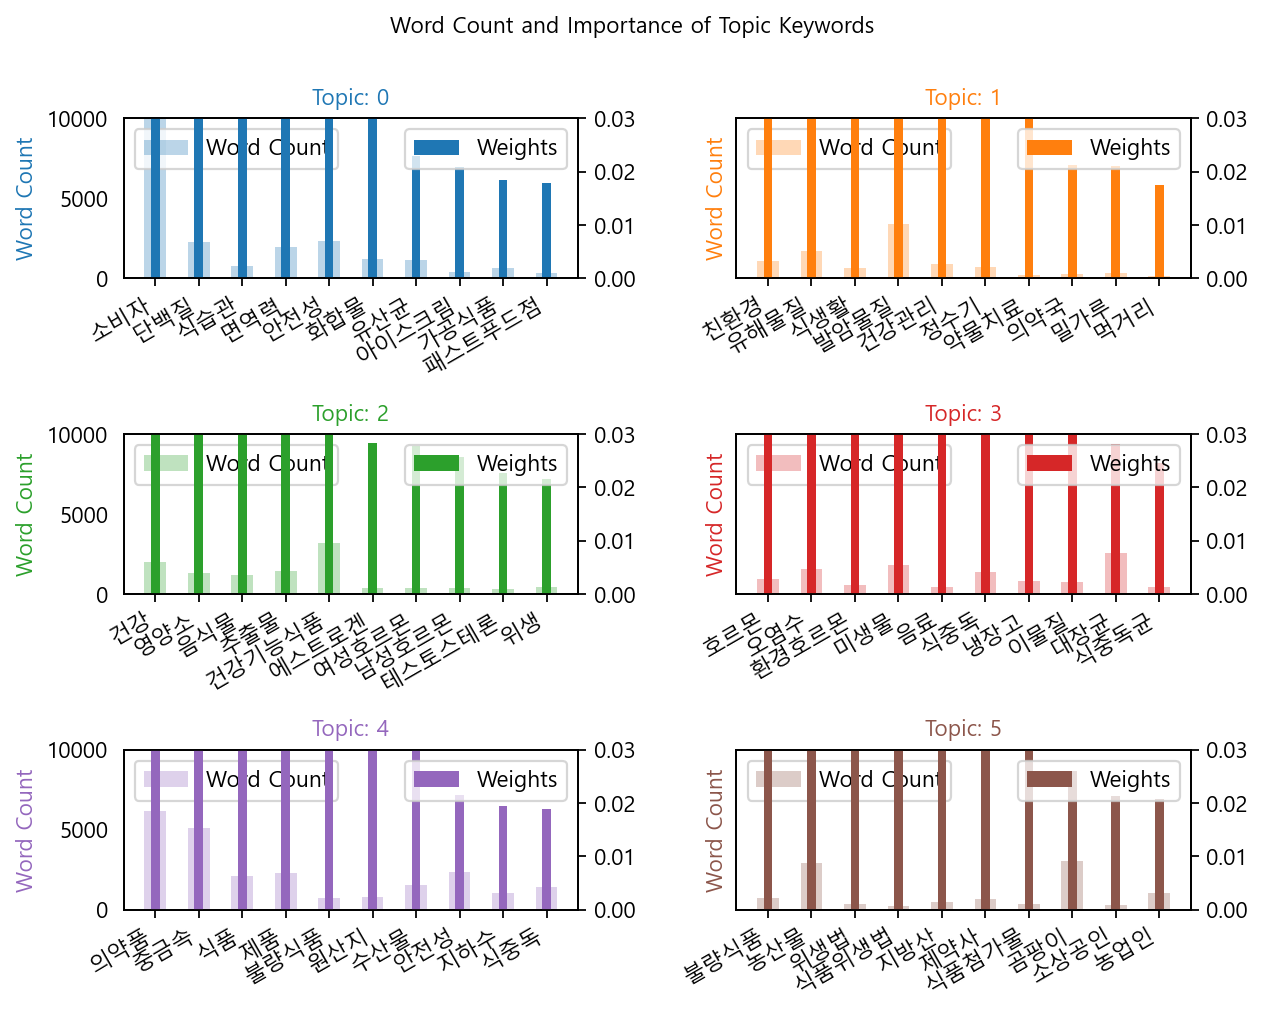

In [64]:
from collections import Counter
import matplotlib.colors as mcolors

topics = model.show_topics(formatted=False)
#topics = model.show_topics(num_words=10, formatted=False)

data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

sf = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(8,6), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=sf.loc[sf.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=sf.loc[sf.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=10)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(sf.loc[sf.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=10, y=1.05)    
plt.show()

In [43]:
#df.to_excel('../data/코로나후.xlsx')

In [65]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
2     -0.00  0.07       1        1 16.18
4      0.20 -0.21       2        1 15.68
0     -0.29 -0.11       3        1 14.13
6     -0.31 -0.09       4        1 12.28
5      0.21 -0.22       5        1 11.41
3      0.09  0.11       6        1 10.90
1      0.03  0.31       7        1  9.71
7      0.08  0.15       8        1  9.70, topic_info=      Term     Freq    Total Category  logprob  loglift
10     소비자 9,066.00 9,066.00  Default    30.00    30.00
11     의약품 4,831.00 4,831.00  Default    29.00    29.00
1408   중금속 4,693.00 4,693.00  Default    28.00    28.00
1997  불량식품 4,611.00 4,611.00  Default    27.00    27.00
1475   호르몬 2,511.00 2,511.00  Default    26.00    26.00
...    ...      ...      ...      ...      ...      ...
1825   허용량   117.95   118.72   Topic8    -5.11     2.33
1553   마라탕   117.78   118.56   Topic8    -5.11     2.33
462    배고픔   114.99   115.76   Topic8    -5.14     2.33
1403  냉동식육   115.15   115.93   Topic8    -5.14     2.33
311    축산물 2,307.39 2,734.92   Topic8    -2.14     2.16

[289 rows x 6 columns], token_table=      Topic  Freq   Term
term                    
197       5  0.99    asf
642       1  1.00    bpa
732       7  0.99    gmo
377       2  0.99  haccp
1371      4  1.00     ph
...     ...   ...    ...
1475      6  1.00    호르몬
406       7  1.00   호르몬제
358       8  1.00   화학물질
250       3  1.00    화합물
664       6  1.00  환경호르몬

[260 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 1, 7, 6, 4, 2, 8])

In [66]:
pyLDAvis.save_html(vis, '../data/코로나전_8_topics.html')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 혼란도와 토픽 응집도를 이용한 최적값 선택

In [67]:
from gensim.models import CoherenceModel

cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print(coherence)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


-10.616081008581451


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


num_topics: 3, perplexity: -6.643, coherence: -7.235
num_topics: 4, perplexity: -6.682, coherence: -7.290
num_topics: 5, perplexity: -6.753, coherence: -8.968
num_topics: 6, perplexity: -6.801, coherence: -10.375
num_topics: 7, perplexity: -6.813, coherence: -11.067
num_topics: 8, perplexity: -6.851, coherence: -11.146
num_topics: 9, perplexity: -6.922, coherence: -12.050
num_topics: 10, perplexity: -6.945, coherence: -12.635
num_topics: 11, perplexity: -7.039, coherence: -13.184
num_topics: 12, perplexity: -7.245, coherence: -12.882
num_topics: 13, perplexity: -7.764, coherence: -12.904
num_topics: 14, perplexity: -8.670, coherence: -13.235
num_topics: 15, perplexity: -10.133, coherence: -13.396


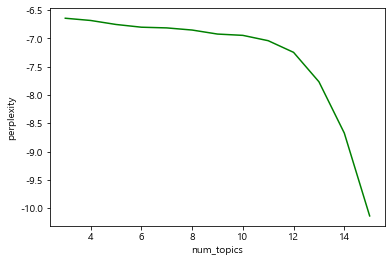

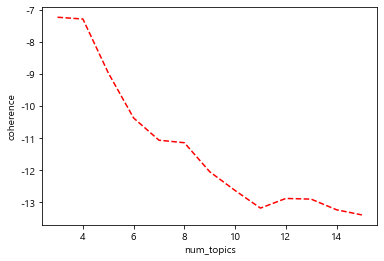

In [68]:
def show_coherence(corpus, dictionary, start=3, end=15):
    iter_num = []
    per_value = []
    coh_value = []

    for i in range(start, end + 1):
        model = LdaModel(corpus=corpus, id2word=dictionary,
                 chunksize=1000, num_topics=i,
                 random_state=7)
        iter_num.append(i)
        pv = model.log_perplexity(corpus)
        per_value.append(pv)
        
        cm = CoherenceModel(model=model, corpus=corpus, 
                            coherence='u_mass')
        cv = cm.get_coherence()
        coh_value.append(cv)
        print(f'num_topics: {i}, perplexity: {pv:0.3f}, coherence: {cv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.xlabel("num_topics")
    plt.ylabel("perplexity")
    plt.show()

    plt.plot(iter_num, coh_value, 'r--')
    plt.xlabel("num_topics")
    plt.ylabel("coherence")
    plt.show()

show_coherence(corpus, dictionary, start=3, end=15)

### Dynamic Topic Modeling in Python
- https://radimrehurek.com/gensim/models/ldaseqmodel.html
-= https://markroxor.github.io/gensim/static/notebooks/ldaseqmodel.html#topic=0&lambda=1&term=

In [61]:
time_slice = df.set_index('일자').resample('3M')['특성추출(가중치순 상위 50개)'].count().tolist()
time_slice

[847,
 2723,
 3280,
 4478,
 5020,
 5271,
 8464,
 7489,
 7748,
 10060,
 12965,
 13683,
 15421,
 8130]

In [91]:
from gensim.test.utils import common_corpus
from gensim.models import LdaSeqModel

#ldaseq = LdaSeqModel(corpus=corpus, time_slice=time_slice, num_topics=4, chunksize=1)

# 문서간 Cosine similarity와 1 kernel density estimation을 이용한 군집 개수 정의
### word2vec cosine similarity

In [74]:
tfidf_matrix = TfidfTransformer().fit_transform(X)
tfidf_matrix.toarray().shape

(105579, 192)

In [75]:
pd.DataFrame(tfidf_matrix.toarray(), columns = vect.get_feature_names()).sample(frac=1, random_state=114)

,bpa,cj제일제당,epa,gmo,haccp,가공식품,간편식,건강,건강 식품,건강관리,...,해산물,해수부,해양수산부,해조류,햄버거병,호르몬,호박즙,화학물질,화합물,환경호르몬
34406,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
tfidf_matrix.shape

(105579, 192)

In [77]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_matrix

MemoryError: Unable to allocate 83.1 GiB for an array with shape (105579, 105579) and data type float64

ValueError: too many values to unpack (expected 3)

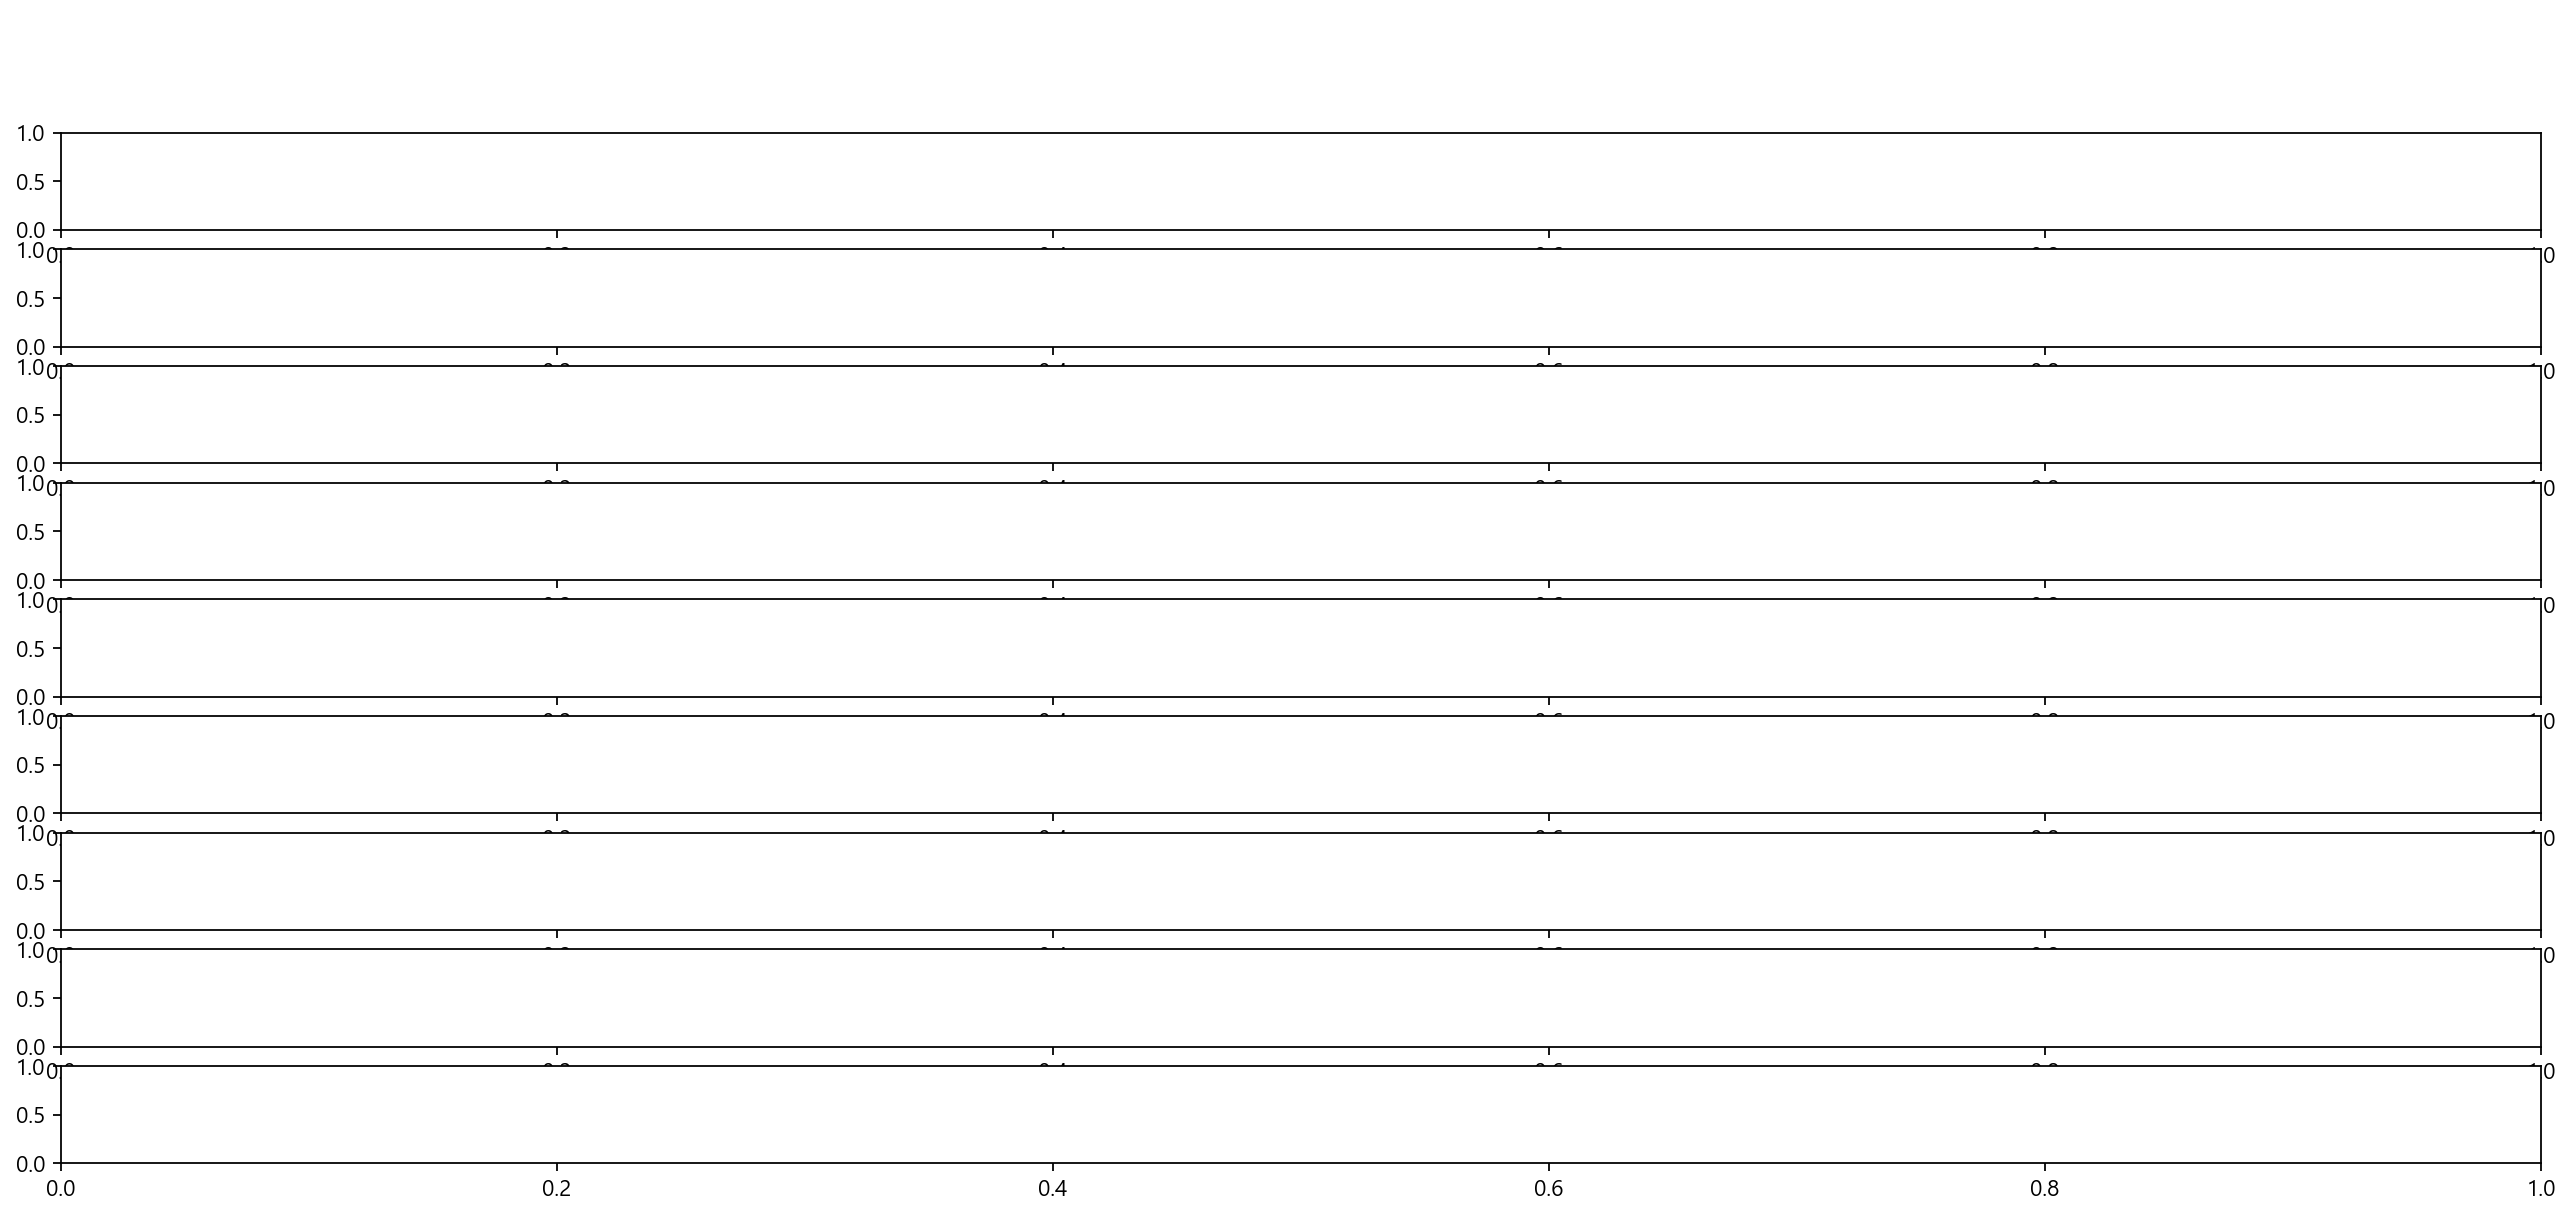

In [36]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=model, corpus=corpus, start = 0, end = 10):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=12, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=12, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=18, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [157]:
data_ready = data_words

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

KeyboardInterrupt: 

In [34]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2,1.0,"그동안,별자리,웬수,부모님,게자리,찜질방,금전운,황소자리,일들,대인관계,동아리회식,...","[시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤..."


In [160]:
# Display setting to show more characters in column
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,2,1.0,"그동안,별자리,웬수,부모님,게자리,찜질방,금전운,황소자리,일들,대인관계,동아리회식,...","[시범판매,밀가루,농산물,밀산업,자급률,병해충,소비자,육성법,소비량,신규제품,16톤..."


<AxesSubplot:>

Text(0.5, 1.0, 'Topic 0')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 1')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 2')

(-0.5, 2499.5, 1799.5, -0.5)

<AxesSubplot:>

Text(0.5, 1.0, 'Topic 3')

(-0.5, 2499.5, 1799.5, -0.5)

(-0.5, 2499.5, 1799.5, -0.5)

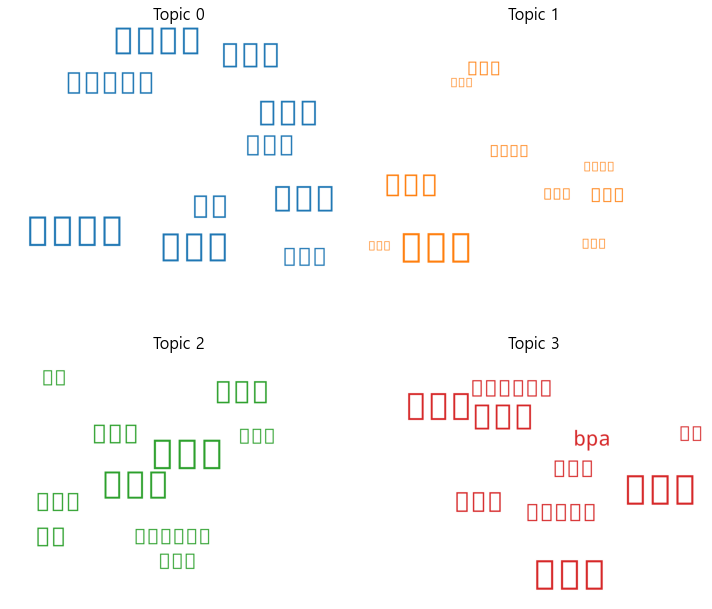

In [56]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

plt.rcParams['font.family']='Malgun Gothic'

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0
                 )

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()